# Deep Learning - Mini Challenge 1
**Author**: Yvo Keller

**Semester**: FS23

## Imports

In [2]:
import os
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchmetrics

import lightning as li
from lightning.pytorch.callbacks import TQDMProgressBar
from lightning.pytorch.loggers import WandbLogger

import wandb
import matplotlib.pyplot as plt
import numpy as np

In [3]:
print(f"Environment Info")

# Device
print(f" | Device: {os.uname().nodename}")

# GPU Env Info
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

else:
    mps_device = torch.device("mps")
    print(f" | MPS Device: {mps_device}")

# CPU Env Info
print(f" | CPU Threads: {torch.get_num_threads()}")

Environment Info
 | Device: mbp-von-yvo.edu.ds.fhnw.ch
 | MPS Device: mps
 | CPU Threads: 12


In [4]:
# Initialize Weights & Biases
os.environ['WANDB_NOTEBOOK_NAME'] = 'mini-challenge-1.ipynb'
wandb.login()

wandb: Currently logged in as: yvokeller (sensor-based-activity-recognition). Use `wandb login --relogin` to force relogin


True

# Schritt 1: Auswahl Task / Datensatz 

1. Mache Dir Gedanken, mit welchen Daten Du arbeiten möchtest und welcher Task gelernt werden soll.  
2. Diskutiere die Idee mit dem Fachcoach.  


**Absprache mit Fachcoach**:

- Deadline: 20. April 2023
- Task: Klassifizierung des CIFAR-10 Datensatzes (32x32 Bilder von 10 Klassen)
- Nutzung von W&B zur Model Evaluation
- [Deep Learning Vorlesungen](https://fleuret.org/dlc/) von Francois Fleuret als Grundlage


# Schritt 2: Daten Kennenlernen 
1. Mache Dich mit dem Datensatz vertraut, indem Du eine (kurze) explorative Analyse der Features durchführst: z.B. Vergleich der Klassen pro Feature, Balanciertheit der Klassen. 
2. Führe ein geeignetes Preprocessing durch, z.B. Normalisierung der Daten.

## Load & Preprocess Dataset 

In [5]:
transform = torchvision.transforms.Compose([
    # 1. transform to pytorch Tensor, which also scales the values to [0, 1]
    torchvision.transforms.ToTensor(), 
    # 2. normalize the tensor with mean (0.5, 0.5, 0.5) and standard deviation (0.5, 0.5, 0.5) for each of the three color channels (RGB) of the image
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) 
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [6]:
def get_dataloaders(batch_size, shuffle=False):
    train_dataloader = torch.utils.data.DataLoader(
        trainset, 
        batch_size=batch_size, 
        num_workers=12,
        shuffle=shuffle, 
        pin_memory=True,
    )

    val_dataloader = torch.utils.data.DataLoader(
        testset,
        batch_size=batch_size, 
        num_workers=12,
        shuffle=shuffle,
        pin_memory=True,
    )

    return train_dataloader, val_dataloader

## Explorative Data Analysis

### Looking at some images

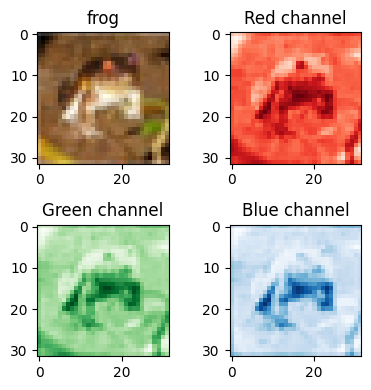

In [7]:
# Plot an image from the dataset
def plot_image(id, dataset):
    img = dataset.data[id]

    fig, axs = plt.subplots(2, 2, figsize=(4, 4))
    axs = axs.flatten()

    axs[0].imshow(img)
    axs[0].set_title(dataset.classes[dataset.targets[id]])

    axs[1].imshow(img[:,:,0], cmap='Reds')
    axs[1].set_title('Red channel')

    axs[2].imshow(img[:,:,1], cmap='Greens')
    axs[2].set_title('Green channel')

    axs[3].imshow(img[:,:,2], cmap='Blues')
    axs[3].set_title('Blue channel')

    plt.tight_layout()
    plt.show()

plot_image(0, trainset)

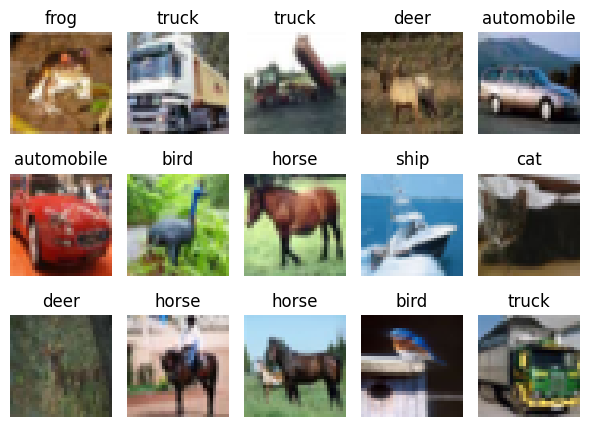

In [8]:
def image_gallery(n_rows=2):
    fig_width = 6
    fig_height = 3 * n_rows / 2
    fig, axs = plt.subplots(n_rows, 5, figsize=(fig_width, fig_height))
    axs = axs.flatten()

    for i in range(n_rows*5):
        img = trainset.data[i]
        axs[i].imshow(img)
        axs[i].set_title(trainset.classes[trainset.targets[i]])
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()

image_gallery(3)

### Class Distribution

As expected based on the dataset's description, the CIFAR10 dataset includes 50'000 images for each class in the training dataset and is therefore balanced.

{6: 5000, 9: 5000, 4: 5000, 1: 5000, 2: 5000, 7: 5000, 8: 5000, 3: 5000, 5: 5000, 0: 5000}


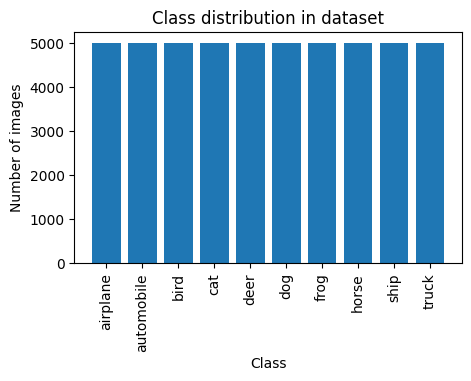

{3: 1000, 8: 1000, 0: 1000, 6: 1000, 1: 1000, 9: 1000, 5: 1000, 7: 1000, 4: 1000, 2: 1000}


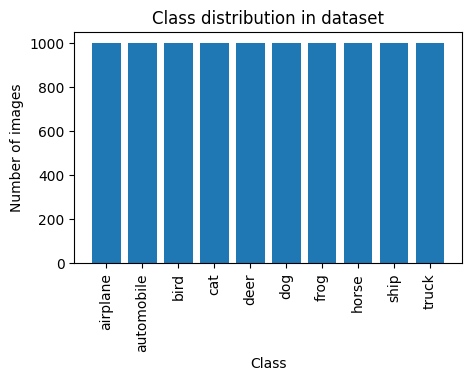

In [9]:
# Check the distribution of the classes in the training set
def show_class_distribution(dataset):
    class_count_dict = {}
    for i in range(len(dataset.targets)):
        if dataset.targets[i] in class_count_dict:
            class_count_dict[dataset.targets[i]] += 1
        else:
            class_count_dict[dataset.targets[i]] = 1
    for i in range(10):
        if i not in class_count_dict:
            class_count_dict[i] = 0

    print(class_count_dict)

    # plot bar plot with target labels
    plt.bar(range(len(class_count_dict)), list(class_count_dict.values()), align='center')
    plt.xticks(range(len(class_count_dict)), dataset.classes, rotation=90)
    plt.xlabel('Class')
    plt.ylabel('Number of images')
    plt.title('Class distribution in dataset')

    fig = plt.gcf()
    fig.set_size_inches(5, 3)

    plt.show()

show_class_distribution(trainset)
show_class_distribution(testset)

# Schritt 3: Aufbau Modellierung

Metriken zur Evaluierung:
- Accuracy
- F1-Score

1. Lege fest, wie (mit welchen Metriken) Du Modelle evaluieren möchtest. 
Berücksichtige auch den Fehler in der Schätzung dieser Metriken.  
2. Implementiere Basisfunktionalität, um Modelle zu trainieren und gegeneinander zu 
evaluieren.  
Empfehlenswert ist die Verwendung einer geeigneten MLOps Plattform (z.B. W&B) 
3. Teste Modelle und Trainingsfunktionalität, indem Du nur mit einem einzigen Sample 
oder einem Batch trainierst. Damit bekommst Du zwar Overfitting, aber auch einen 
guten Test, der zeigt dass Information aus den Daten aufgenommen werden kann.

Notes:
- Komplexität/Tiefe des Modells variieren
- Bei CNN: Filter Grössen variieren
- Hyperparameter -> Tuning reicht bei einem Modell

## Wahl der Evaluierungsmetriken

Ich wähle als Evaluierungsmetrik für meine Deep Learning Modelle auf dem CIFAR-10 Datensatz die **Accuracy**. CIFAR-10 besteht, wie ich im Schritt 2 überprüft habe, aus 10 gleichmässig verteilten Klassen, wobei jede Klasse die gleiche Anzahl von Samples enthält. Damit ist die Accuracy ein angemessene Metrik für die Model Performance - sie misst den Anteil der korrekt klassifizierten Samples im Vergleich zur Gesamtanzahl der Samples. Die Accuracy kann wie folgt definiert werden:

$$
\text{Accuracy} = \frac{\text{Anzahl der korrekt klassifizierten Samples}}{\text{Gesamtanzahl der Samples}}
$$

Der **F1-Score** ist ein weiterer möglicher Kandidat als Evaluierungsmetrik, und misst das harmonische Mittel von Precision und Recall. In Szenarien, in denen der Datensatz unausgeglichen ist oder die Leistung des Modells in Bezug auf bestimmte Klassen von besonderem Interesse ist, kann der F1-Score nützlich sein. Da der CIFAR-10 Datensatz jedoch ausgeglichen ist und ich keine spezielle Anforderung an bestimmte Klassen habe, bietet der F1-Score keinen zusätzlichen Vorteil gegenüber der Accuracy.


## Schätzung des Fehlers

Hat man ein Modell 1 mal trainiert, kann nicht mit Sicherheit gesagt werden, dass die resultierende Accuracy des Modells genau dem entspricht. Trainiert man das Modell ein zweites Mal mit den gleichen Daten, wird eine etwas andere Accuracy resultieren. Dies hängt mit dem Random State (initialisierung der weights, train/test split, ...) zusammen.

Es macht deshalb Sinn, die Variabilität der Model Performance abzuschätzen. Dazu gibt es mehrere Methoden, von denen ich 3 kurz aufzeigen will.

1. **Mehrere Runs**: Um die Variabilität der Model Performance zu schätzen und ein besseres Verständnis dafür zu bekommen, wie das Modell auf unterschiedliche Trainingsbedingungen reagiert, kann man ein Model mehrmals (z. B. 10 Runs) mit unterschiedlichem Random State und/oder verschiedenen Trainings-/Testdaten-Splits trainieren und evaluieren. Durch das Berechnen des Durchschnitts und der Standardabweichung der Accuracy über alle Runs erhält man eine Schätzung der Model Performance über verschiedene Trainingsbedingungen.

2. **Cross-Validation**: Eine weitere Methode zur Bewertung der Model Performance und Abschätzung ihrer Unsicherheit ist k-Fold Cross-Validation. Dabei wird der Datensatz in k gleiche Teile (Folds) aufgeteilt und das Modell k-mal trainiert und validiert. In jedem Durchlauf wird jeweils ein Fold als Validierungsdatensatz und die verbleibenden k-1 Folds als Trainingsdatensatz verwendet. Nach Abschluss der k Iterationen kann man den Durchschnitt und die Standardabweichung der Accuracy über alle Folds berechnen, um Einblick in die Stabilität der Model Performance über verschiedene Trainings-/Validierungsdaten-Splits zu erhalten.

Beide Methoden erfordern zusätzliche Rechenzeit und Ressourcen, insbesondere bei grossen Datensätzen und komplexen Modellen. Eine weitere Möglichkeit, die ich gefunden habe, und die nur einen Run erfordert, ist die Berechnung des Konfidenzintervalls mittels Wilson Score.

3. **Wilson Score Interval**: Um den Fehler in der Schätzung der Accuracy zu berücksichtigen, kann man das Konfidenzintervall berechnen. Dieses gibt an, in welchem Bereich man den wahren Wert der Accuracy mit einer bestimmten Wahrscheinlichkeit (z.B. 95 %) erwarten kann. Es resultiert in einer oberen und unteren Grenze, die man zusätzlich zur Accuracy angeben kann.

## Testen der Trainingsfunktionalität

Ich trainiere ein einfaches Modell auf nur einem Batch.

In [10]:
class SimpleCNN(li.LightningModule):
    """
    A simple convolutional neural network (CNN) for image classification tasks.
    """

    def __init__(self, learning_rate, optimizer):
        super().__init__()

        # Save hyperparameters
        self._learning_rate = learning_rate
        self._optimizer = optimizer

        # Initialize the network layers
        # @ Define the CNN architecture with a single convolutional layer, 3 input channels (RGB) and 16 output channels (filters)
        self.conv1 = nn.Conv2d(
            in_channels=3, out_channels=16, kernel_size=3, padding=1
        )  # from dimension (batch_size, 3, H, W) to (batch_size, 16, H, W)

        # @ Using max-pooling layer to keep only the max value in each 2x2 (size=2) window of the 16 filters, moving 2 pixels at a time (stride=2)
        self.pool = nn.MaxPool2d(
            kernel_size=2, stride=2
        )  # from dimension (batch_size, 16, H, W) to (batch_size, 16, H/2, W/2)

        # @ Fully connected output layer
        self.fc1 = nn.Linear(
            16 * 16 * 16, 10
        )  # takes (batch_size, 16, H/2, W/2) to (batch_size, 10) for our classification task

        # Initialize metrics
        self.train_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=10)
        self.val_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=10)

    def forward(self, x):
        """
        Forward pass through the CNN.

        Args:
            x (torch.Tensor): Input tensor with shape (batch_size, 3, 32, 32).

        Returns:
            torch.Tensor: Output tensor with shape (batch_size, 10).
        """
        x = self.pool(
            F.relu(self.conv1(x))
        )  # ReLU activation function to introduce non-linearity
        x = x.view(
            -1, 16 * 16 * 16
        )  # Flatten the output of the convolutional layer (-1 means that the batch size is inferred by PyTorch)
        x = self.fc1(x)  # Fully connected output layer
        return x

    def configure_optimizers(self):
        """
        Set up the optimizer for the CNN.

        Returns:
            torch.optim.Optimizer: The optimizer for this model.
        """
        # Update model parameters using Adam, which combines the ideas of momentum and adaptive learning rates
        if self._optimizer == "SGD":
            return torch.optim.SGD(self.parameters(), lr=self._learning_rate)
        elif self._optimizer == "Adam":
            return torch.optim.Adam(
                self.parameters(), lr=self._learning_rate
            )  # self.parameters() returns current model params; lr is the initial learning rate
        else:
            raise ValueError("Optimizer not supported.")

    def training_step(self, batch, batch_idx):
        """
        Perform a single training step.

        Args:
            batch (tuple): A tuple containing the input and target tensors.
            batch_idx (int): The index of the current batch.

        Returns:
            torch.Tensor: The training loss for the current batch.
        """
        inputs, targets = batch
        outputs = self(inputs)  # equivalent to self.forward(inputs)
        loss = F.cross_entropy(outputs, targets)
        preds = torch.argmax(outputs, dim=1)

        # Log training accuracy
        self.train_accuracy(preds, targets)
        self.log(
            "train_accuracy",
            self.train_accuracy,
            on_step=False,
            on_epoch=True,
            prog_bar=True,
            logger=True,
        )

        # Log training loss
        self.log(
            "train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True
        )
        return loss

    def validation_step(self, batch, batch_idx):
        """
        Perform a single validation step.

        Args:
            batch (tuple): A tuple containing the input and target tensors.
            batch_idx (int): The index of the current batch.

        Returns:
            None
        """
        inputs, targets = batch
        outputs = self(inputs)  # equivalent to self.forward(inputs)
        loss = F.cross_entropy(outputs, targets)
        preds = torch.argmax(outputs, dim=1)

        # log validation accuracy
        self.val_accuracy(preds, targets)
        self.log(
            "val_accuracy",
            self.val_accuracy,
            on_step=False,
            on_epoch=True,
            prog_bar=True,
            logger=True,
        )

        # Log validation loss
        self.log(
            "val_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True
        )
        return loss


In [11]:
# Configure Weights & Biases sweeps
sweep_config = {
    "name": "simple-cnn-singlebatch",
    "method": "grid",
    "metric": {
        "name": "val_accuracy_epoch",
        "goal": "maximize",
    },
    "parameters": {
        "epochs": {"values": [15]},
        "learning_rate": {"values": [1e-3]},
        "optimizer": {"values": ["SGD", "Adam"]},
    },
}

# Setup Weight & Biases
sweep_id = wandb.sweep(sweep_config, entity="yvokeller", project="deep-learning")

# Create the PyTorch Lightning Trainer
def train_sweep():
    wandb.init()

    model = SimpleCNN(wandb.config.learning_rate, wandb.config.optimizer)

    trainer = li.Trainer(
        max_epochs=wandb.config.epochs,
        limit_train_batches=1,
        limit_val_batches=1,
        logger=WandbLogger(entity="yvokeller", project="deep-learning"),
        log_every_n_steps=1,
        enable_progress_bar=True,
        callbacks=[TQDMProgressBar(refresh_rate=10)],  # update every 10 batches
    )

    train_dataloader, val_dataloader = get_dataloaders(batch_size=32)

    trainer.fit(model, train_dataloader, val_dataloader)
    wandb.finish()


# Run the sweep
# wandb.agent(sweep_id, function=train_sweep)

Create sweep with ID: rscead7t
Sweep URL: https://wandb.ai/yvokeller/deep-learning/sweeps/rscead7t


Runs:
- solar-sweep-1
- restful-sweep-2

https://wandb.ai/yvokeller/deep-learning/reports/Deep-Learning--Vmlldzo0MDM1MzE1

# Schritt 4: Evaluation

### Interface Definition

In [10]:
class IModel(li.LightningModule):
    def __init__(self, hparams):
        super().__init__()

        # Save hyperparameters
        self.hparams.update(hparams)

        # Initialize metrics
        self.train_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=10)
        self.val_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=10)

        # Configure optimizers
        if self.hparams.optimizer == "SGD":
            self.configure_optimizers = self.__configure_optimizers_sgd
        elif self.hparams.optimizer == "Adam":
            self.configure_optimizers = self.__configure_optimizers_adam
        else:
            raise ValueError("Optimizer not supported.")

    def init_weights(self, m):
        if type(m) in {nn.Conv2d, nn.Linear}:
            # Only initialize the weights of the convolutional and linear layers
            # TODO: Look into the difference between the different weight initialization methods
            if self.hparams.init_method == "xavier_uniform":
                nn.init.xavier_uniform_(m.weight)
            elif self.hparams.init_method == "kaiming_uniform":
                nn.init.kaiming_uniform_(m.weight)
            elif self.hparams.init_method == "xavier_normal":
                nn.init.xavier_normal_(m.weight)
            elif self.hparams.init_method == "kaiming_normal":
                nn.init.kaiming_normal_(m.weight)
            elif self.hparams.init_method is None:
                pass
            else:
                raise ValueError("Invalid initialization method.")
            if m.bias is not None:
                nn.init.zeros_(m.bias)

    def training_step(self, batch, batch_idx):
        return self.__step(batch, batch_idx, "train", self.train_accuracy)

    def validation_step(self, batch, batch_idx):
        return self.__step(batch, batch_idx, "val", self.val_accuracy)

    def __configure_optimizers_adam(self):
        return torch.optim.Adam(
            self.parameters(),
            lr=self.hparams.learning_rate,
        )

    def __configure_optimizers_sgd(self):
        return torch.optim.SGD(
            self.parameters(),
            lr=self.hparams.learning_rate,
        )

    def __step(self, batch, batch_idx, stage, metric):
        inputs, targets = batch
        outputs = self(inputs)
        loss = F.cross_entropy(outputs, targets)
        preds = torch.argmax(outputs, dim=1)

        # Log training accuracy
        metric(preds, targets)
        self.log(
            f"{stage}_accuracy",
            metric,
            on_step=False,
            on_epoch=True,
            prog_bar=True,
            logger=True,
        )

        # Log training loss
        self.log(
            f"{stage}_loss",
            loss,
            on_step=False,
            on_epoch=True,
            prog_bar=True,
            logger=True,
        )
        return loss


In [11]:
class CNNModel(IModel):
    def __init__(
        self,
        hparams
    ):
        super().__init__(hparams)

        # Initialize the network layers
        self.conv1 = nn.Conv2d(
            3, 32, self.hparams.kernel_size, stride=self.hparams.stride, padding=self.hparams.padding, dilation=self.hparams.dilation
        )
        # output_size = (input_size - kernel_size + 2 * padding / stride + 1)
        # (32 - 5 + 2 * 0 / 1 + 1) * (32 - 5 + 2 * 0 / 1 + 1) * 32 [28]
        self.conv2 = nn.Conv2d(
            32, 64, self.hparams.kernel_size, stride=self.hparams.stride, padding=self.hparams.padding, dilation=self.hparams.dilation
        )
        # (28 - 5 + 2 * 0 / 1 + 1) * (28 - 5 + 2 * 0 / 1 + 1) * 64 [24]
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        # floor((input_size - pool_size) / stride + 1)
        # floor((24 - 2) / 2 + 1) = 12
        self.conv3 = nn.Conv2d(
            64, 128, self.hparams.kernel_size, stride=self.hparams.stride, padding=self.hparams.padding, dilation=self.hparams.dilation
        )
        # (12 - 5 + 2 * 0 / 1 + 1) * (12 - 5 + 2 * 0 / 1 + 1) * 128 [8]
        self.conv4 = nn.Conv2d(
            128, 256, self.hparams.kernel_size, stride=self.hparams.stride, padding=self.hparams.padding, dilation=self.hparams.dilation
        )
        # (8 - 5 + 2 * 0 / 1 + 1) * (8 - 5 + 2 * 0 / 1 + 1) * 256 [4]
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        # floor((4 - 2) / 2 + 1) = 2

        # Calculate the size of the fully connected layers based on the input hyperparameters
        size_after_pooling = 2 # 32 // (2**2)  # Divide by 2 for each max-pooling layer
        fc_input_size = 256 * size_after_pooling * size_after_pooling

        self.fc1 = nn.Linear(fc_input_size, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    

In [12]:
# Configure Weights & Biases sweeps
sweep_config = {
    "name": "medium-cnn-sweep",
    "method": "grid",
    "metric": {
        "name": "val_accuracy",
        "goal": "maximize",
    },
    "parameters": {
        "epochs": {"values": [30]},
        "learning_rate": {"values": [1e-3]},
        "batch_size": {"values": [64]},
        "optimizer": {"values": ["SGD"]},
        "init_method": {"values": [None]},
        "kernel_size": {"values": [5]},
        "stride": {"values": [1]}, # 1 is default
        "padding": {"values": [0]}, # 0 is default
        "dilation": {"values": [1]}, # 1 is default
    },
}

# Setup Weight & Biases
sweep_id = wandb.sweep(
    sweep_config, entity='yvokeller', project='deep-learning'
)

def is_valid_hyperparameters(kernel_size, stride, padding, dilation):
    input_size = 32  # Assuming the input image size is 32x32
    num_pooling_layers = 2

    for _ in range(4):  # There are four convolutional layers in the network
        output_size = (input_size + 2 * padding - dilation * (kernel_size - 1) - 1) // stride + 1
        if output_size < kernel_size:
            return False
        input_size = output_size
        if num_pooling_layers > 0:
            input_size = input_size // 2  # Divide by 2 for each max-pooling layer
            num_pooling_layers -= 1

    return True

# Create the PyTorch Lightning Trainer
def train_sweep():
    with wandb.init() as run:
        # # Check if the combination of hyperparameters is valid
        # if not is_valid_hyperparameters(run.config.kernel_size, run.config.stride, run.config.padding, run.config.dilation):
        #     wandb.termlog("Invalid combination of hyperparameters. Skipping this run.")
        #     return
        
        # Overwrite the random run names chosen by wandb
        name_str = (
            f"lr_{run.config.learning_rate}_"
            f"opt_{run.config.optimizer}_"
            f"bs_{run.config.batch_size}_"
            f"ks_{run.config.kernel_size}_"
            f"str_{run.config.stride}_"
            f"pad_{run.config.padding}_"
            f"ini_{run.config.init_method}"
        )
        run.name = name_str

        model = CNNModel(run.config)

        # Initialize weights
        model.apply(
            model.init_weights
        ) # traverse through the layers and initialize the weights

        trainer = li.Trainer(
            max_epochs=wandb.config.epochs,
            logger=WandbLogger(entity='yvokeller', project='deep-learning'),
            log_every_n_steps=1,
            enable_progress_bar=True,
            callbacks=[TQDMProgressBar(refresh_rate=10)] # update every 10 batches
        )

        train_dataloader, val_dataloader = get_dataloaders(batch_size=wandb.config.batch_size)

        trainer.fit(model, train_dataloader, val_dataloader)

# Run the sweep
wandb.agent(sweep_id, function=train_sweep)

Create sweep with ID: rpsj7s3n
Sweep URL: https://wandb.ai/yvokeller/deep-learning/sweeps/rpsj7s3n


wandb: Agent Starting Run: 8tlcwpl2 with config:
wandb: 	batch_size: 64
wandb: 	dilation: 1
wandb: 	epochs: 30
wandb: 	init_method: None
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.001
wandb: 	optimizer: SGD
wandb: 	padding: 0
wandb: 	stride: 1
wandb: Currently logged in as: yvokeller. Use `wandb login --relogin` to force relogin


/opt/homebrew/Caskroom/miniforge/base/envs/deep-learning/lib/python3.10/site-packages/lightning/pytorch/loggers/wandb.py:395: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name           | Type               | Params
------------------------------------------------------
0 | train_accuracy | MulticlassAccuracy | 0     
1 | val_accuracy   | MulticlassAccuracy | 0     
2 | conv1          | Conv2d             | 2.4 K 
3 | conv2          | Conv2d             | 51.3 K
4 | pool1          | MaxPool2d          | 0     
5 | conv3          | Conv2d             | 204 K 
6 | conv4          | Conv2d             | 819 K 
7 | pool2          | MaxPool2d          | 0     
8 | fc

Sanity Checking: 0it [00:00, ?it/s]

/opt/homebrew/Caskroom/miniforge/base/envs/deep-learning/lib/python3.10/site-packages/torch/functional.py:791: UserWarning: The operator 'aten::_unique2' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:11.)
  output, inverse_indices, counts = torch._unique2(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

## Defining Models of different complexity

In [14]:
class MediumCNN(li.LightningModule):
    def __init__(
        self,
        learning_rate,
        optimizer,
        init_method,
        kernel_size,
        stride,
        padding,
        dilation,
    ):
        super().__init__()

        # Save hyperparameters
        self.save_hyperparameters()  # saves all the arguments passed to the __init__ method

        # Initialize the network layers
        self.conv1 = nn.Conv2d(
            3, 32, kernel_size, stride=stride, padding=padding, dilation=dilation
        )
        self.conv2 = nn.Conv2d(
            32, 64, kernel_size, stride=stride, padding=padding, dilation=dilation
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(
            64, 128, kernel_size, stride=stride, padding=padding, dilation=dilation
        )
        self.conv4 = nn.Conv2d(
            128, 256, kernel_size, stride=stride, padding=padding, dilation=dilation
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Calculate the size of the fully connected layers based on the input hyperparameters
        size_after_pooling = 32 // (2**2)  # Divide by 2 for each max-pooling layer
        fc_input_size = 256 * size_after_pooling * size_after_pooling

        self.fc1 = nn.Linear(fc_input_size, 512)
        self.fc2 = nn.Linear(512, 10)

        # Initialize metrics
        self.train_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=10)
        self.val_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=10)

        # Initialize weights
        self.apply(
            self._init_weights
        ) # traverse through the layers and initialize the weights

    def _init_weights(self, m):
        if type(m) in {nn.Conv2d, nn.Linear}:
            # Only initialize the weights of the convolutional and linear layers
            # TODO: Look into the difference between the different weight initialization methods
            if self.hparams.init_method == "xavier_uniform":
                nn.init.xavier_uniform_(m.weight)
            elif self.hparams.init_method == "kaiming_uniform":
                nn.init.kaiming_uniform_(m.weight)
            elif self.hparams.init_method == "xavier_normal":
                nn.init.xavier_normal_(m.weight)
            elif self.hparams.init_method == "kaiming_normal":
                nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
            elif self.hparams.init_method is None:
                pass
            else:
                raise ValueError("Invalid initialization method.")
            if m.bias is not None:
                nn.init.zeros_(m.bias)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def configure_optimizers(self):
        if self.hparams.optimizer == "SGD":
            return torch.optim.SGD(self.parameters(), lr=self.hparams.learning_rate)
        elif self.hparams.optimizer == "Adam":
            return torch.optim.Adam(self.parameters(), lr=self.hparams.learning_rate)
        else:
            raise ValueError("Optimizer not supported.")

    def training_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self(inputs)
        loss = F.cross_entropy(outputs, targets)
        preds = torch.argmax(outputs, dim=1)

        # Log training accuracy
        self.train_accuracy(preds, targets)
        self.log(
            "train_accuracy",
            self.train_accuracy,
            on_step=False,
            on_epoch=True,
            prog_bar=True,
            logger=True,
        )

        # Log training loss
        self.log(
            "train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True
        )
        return loss

    def validation_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self(inputs)
        loss = F.cross_entropy(outputs, targets)
        preds = torch.argmax(outputs, dim=1)

        # Log validation accuracy
        self.val_accuracy(preds, targets)
        self.log(
            "val_accuracy",
            self.val_accuracy,
            on_step=False,
            on_epoch=True,
            prog_bar=True,
            logger=True,
        )

        # Log validation loss
        self.log(
            "val_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True
        )
        return loss


In [15]:
# Configure Weights & Biases sweeps
sweep_config = {
    "name": "medium-cnn-sweep",
    "method": "grid",
    "metric": {
        "name": "val_accuracy",
        "goal": "maximize",
    },
    "parameters": {
        "epochs": {"values": [15]},
        "learning_rate": {"values": [1e-2, 1e-3, 1e-4]},
        "batch_size": {"values": [32, 64, 128]},
        "optimizer": {"values": ["SGD"]},
        "init_method": {"values": [None, "xavier_uniform", "kaiming_uniform"]},
        "kernel_size": {"values": [3, 5]},
        "stride": {"values": [1, 2]}, # 1 is default
        "padding": {"values": [0, 1, 2]}, # 0 is default
        "dilation": {"values": [1, 2]}, # 1 is default
    },
}

# Setup Weight & Biases
sweep_id = wandb.sweep(
    sweep_config, entity='yvokeller', project='deep-learning'
)

def is_valid_hyperparameters(kernel_size, stride, padding, dilation):
    input_size = 32  # Assuming the input image size is 32x32
    num_pooling_layers = 2

    for _ in range(4):  # There are four convolutional layers in the network
        output_size = (input_size + 2 * padding - dilation * (kernel_size - 1) - 1) // stride + 1
        if output_size < kernel_size:
            return False
        input_size = output_size
        if num_pooling_layers > 0:
            input_size = input_size // 2  # Divide by 2 for each max-pooling layer
            num_pooling_layers -= 1

    return True

# Create the PyTorch Lightning Trainer
def train_sweep():
    with wandb.init() as run:
        # Check if the combination of hyperparameters is valid
        if not is_valid_hyperparameters(run.config.kernel_size, run.config.stride, run.config.padding, run.config.dilation):
            wandb.termlog("Invalid combination of hyperparameters. Skipping this run.")
            return
        
        # Overwrite the random run names chosen by wandb
        name_str = (
            f"lr_{run.config.learning_rate}_"
            f"opt_{run.config.optimizer}_"
            f"bs_{run.config.batch_size}_"
            f"ks_{run.config.kernel_size}_"
            f"str_{run.config.stride}_"
            f"pad_{run.config.padding}_"
            f"ini_{run.config.init_method}"
        )
        run.name = name_str

        model = MediumCNN(
            learning_rate=wandb.config.learning_rate,
            optimizer=wandb.config.optimizer,
            init_method=wandb.config.init_method,
            kernel_size=wandb.config.kernel_size,
            stride=wandb.config.stride,
            padding=wandb.config.padding,
            dilation=wandb.config.dilation
        )

        trainer = li.Trainer(
            max_epochs=wandb.config.epochs,
            logger=WandbLogger(entity='yvokeller', project='deep-learning'),
            log_every_n_steps=1,
            enable_progress_bar=True,
            callbacks=[TQDMProgressBar(refresh_rate=10)] # update every 10 batches
        )

        train_dataloader, val_dataloader = get_dataloaders(batch_size=wandb.config.batch_size)

        trainer.fit(model, train_dataloader, val_dataloader)

# Run the sweep
wandb.agent(sweep_id, function=train_sweep)

Create sweep with ID: 3yfan4jc
Sweep URL: https://wandb.ai/yvokeller/deep-learning/sweeps/3yfan4jc


wandb: Agent Starting Run: reo8g3lr with config:
wandb: 	batch_size: 32
wandb: 	dilation: 1
wandb: 	epochs: 15
wandb: 	init_method: None
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.01
wandb: 	optimizer: SGD
wandb: 	padding: 0
wandb: 	stride: 1
wandb: Currently logged in as: yvokeller. Use `wandb login --relogin` to force relogin


wandb: Invalid combination of hyperparameters. Skipping this run.


wandb: Agent Starting Run: 4biw3xmc with config:
wandb: 	batch_size: 32
wandb: 	dilation: 1
wandb: 	epochs: 15
wandb: 	init_method: None
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.01
wandb: 	optimizer: SGD
wandb: 	padding: 0
wandb: 	stride: 2


wandb: Invalid combination of hyperparameters. Skipping this run.


wandb: Agent Starting Run: yintey8m with config:
wandb: 	batch_size: 32
wandb: 	dilation: 1
wandb: 	epochs: 15
wandb: 	init_method: None
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.01
wandb: 	optimizer: SGD
wandb: 	padding: 1
wandb: 	stride: 1


/opt/homebrew/Caskroom/miniforge/base/envs/deep-learning/lib/python3.10/site-packages/lightning/pytorch/loggers/wandb.py:395: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name           | Type               | Params
------------------------------------------------------
0 | conv1          | Conv2d             | 896   
1 | conv2          | Conv2d             | 18.5 K
2 | pool1          | MaxPool2d          | 0     
3 | conv3          | Conv2d             | 73.9 K
4 | conv4          | Conv2d             | 295 K 
5 | pool2          | MaxPool2d          | 0     
6 | fc1            | Linear             | 8.4 M 
7 | fc2            | Linear             | 5.1 K 
8 | tr

Sanity Checking: 0it [00:00, ?it/s]

/opt/homebrew/Caskroom/miniforge/base/envs/deep-learning/lib/python3.10/site-packages/torch/functional.py:791: UserWarning: The operator 'aten::_unique2' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:11.)
  output, inverse_indices, counts = torch._unique2(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.


epoch,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇███
train_accuracy,▁▃▃▄▅▅▅▆▆▇▇████
train_loss_epoch,█▆▆▅▅▄▄▃▃▂▂▁▁▁▁
train_loss_step,█▇▇▆▇▅▅▆▅▄▆▅▄▄▃▄▄▃▃▃▂▃▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▂▂▁▂▂▂▃▃▃▃▃▄▄▄▄▂▅▅▅▅▂▅▆▂▆▆▆▆▂▇▇▇▇███▂
val_accuracy,▁▃▄▅▆▇▇▇███▇███
val_loss_epoch,█▅▄▃▂▁▁▁▁▂▃▆▅▆▇
val_loss_step,▄▅▅▄▃▄▃▄▂▄▂▂▃▁▁▁▃▃▃▄▄▄▂▃▃▁▇▃▃▃▂▁▃▃█▅▄▄▄▄
epoch,14
train_accuracy,0.9761
train_loss_epoch,0.07495


wandb: Agent Starting Run: 1xhlvrzq with config:
wandb: 	batch_size: 32
wandb: 	dilation: 1
wandb: 	epochs: 15
wandb: 	init_method: None
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.01
wandb: 	optimizer: SGD
wandb: 	padding: 1
wandb: 	stride: 2


wandb: Invalid combination of hyperparameters. Skipping this run.


wandb: Agent Starting Run: o62otwq7 with config:
wandb: 	batch_size: 32
wandb: 	dilation: 1
wandb: 	epochs: 15
wandb: 	init_method: None
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.01
wandb: 	optimizer: SGD
wandb: 	padding: 2
wandb: 	stride: 1


/opt/homebrew/Caskroom/miniforge/base/envs/deep-learning/lib/python3.10/site-packages/lightning/pytorch/loggers/wandb.py:395: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name           | Type               | Params
------------------------------------------------------
0 | conv1          | Conv2d             | 896   
1 | conv2          | Conv2d             | 18.5 K
2 | pool1          | MaxPool2d          | 0     
3 | conv3          | Conv2d             | 73.9 K
4 | conv4          | Conv2d             | 295 K 
5 | pool2          | MaxPool2d          | 0     
6 | fc1            | Linear             | 8.4 M 
7 | fc2            | Linear             | 5.1 K 
8 | tr

Sanity Checking: 0it [00:00, ?it/s]

: 

: 